# 千葉工業大学未来ロボティクス学科
## 確率ロボティクス特論

学籍番号: 1776033 ルコント・トリスタン

## 課題1

課題1 : MCLの実装
   2-5回のコードをうまく組み合わせて、パーティクルフィルタによる自己位置推定（Monte Carlo localization）のコードを書く
 - 移動更新
 - センサー更新
 - リサンプリング
    - センサ更新の直後に適用すると良い

## パケージのインポート

In [47]:
import numpy as np
import copy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

## シミュレーション表示用の関数設定

In [48]:
#ワールド設定
class World(object):
    #表示更新
    def update(self, path, particle_path, actual_landmarks, measurements):
        for i, p in enumerate(path):
            self.draw_agent_pose(path[i], particle_path[i])
            self.draw_landmarks(actual_landmarks)
            self.draw_agent_observations(path[i], measurements[i])
            plt.show()
    #姿勢表示
    def draw_agent_pose(self, pose, particles):
        fig = plt.figure(i, figsize=(8,8))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0, 1.0)
        sp.set_ylim(-0.5, 1.5)

        xs = [e.pose[0] for e in particles]
        ys = [e.pose[1] for e in particles]
        vxs = [math.cos(e.pose[2]) for e in particles]
        vys = [math.sin(e.pose[2]) for e in particles]
        col = [e.weight for e in particles]
        fig = plt.quiver(xs, ys, vxs, vys, color='blue', label="particles")
        plt.quiver([pose[0]], [pose[1]], [math.cos(pose[2])], [math.sin(pose[2])],color="red",label="actual robot motion")
    #ランドマーク表示
    def draw_landmarks(self, landmarks):
        xs = [e [0] for e in landmarks]
        ys = [e [1] for e in landmarks]
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
    #えジェント計測
    def draw_agent_observations(self, pose, measurements):
        x,y,th = pose
        for measurement in measurements:
            distance, direction, lx, ly = measurement
            lx = distance * math.cos(th + direction) + x
            ly = distance * math.sin(th + direction) + y
            plt.plot([x, lx], [y, ly], color='pink')

## エージェント定義
* エージェントの行動（制御出力）と観察（センサ入力）を定義する
* エージェントの検出範囲を限る

In [49]:
#エージェント
class Agent(object):
    def relative_landmark_pos(self, pose, landmark):
        x,y,th = pose
        lx, ly = landmark
        distance = math.sqrt((x-lx)**2 + (y-ly)**2)
        direction = math.atan2(ly-y, lx-x) - th

        return (distance, direction, lx, ly)

    def observation(self, pose, landmark):
        actual_distance, actual_direction, lx, ly = self.relative_landmark_pos(pose, landmark)
        # センサー計測範囲制限
        if math.cos(actual_direction) < 0.0: #左右90度のみ.前身の計測のみ.
            return None
        
        measured_distance = random.gauss(actual_distance, actual_distance*0.1) #エラー率: 10%
        measured_direction = random.gauss(actual_direction, 5.0/180.0*math.pi) #エラー角度: 5度
        return (measured_distance, measured_direction, lx, ly)

    # 観測
    def observations(self, pose, landmarks):
        return filter(lambda x: x != None, [self.observation(pose,e) for e in landmarks])
    
    # 移動
    def move(self, old_x, u):
        pos_x, pos_y, pos_th = old_x
        act_fw, act_rot = u
        
        act_fw = random.gauss(act_fw, act_fw/10) 
        dir_error = random.gauss(0, math.pi/180*3) 
        act_rot = random.gauss(act_rot, act_rot/10) 
        
        pos_x += act_fw * math.cos(pos_th + dir_error)
        pos_y += act_fw * math.sin(pos_th + dir_error)
        pos_th += act_rot

        return np.array([pos_x, pos_y, pos_th])
    # 確率
    def likelihood(self, pose, measurement):
        distance, direction, lx, ly = measurement
        
        # パーティクル計測の予測
        rel_distance, rel_direction, tmp_x, tmp_y = self.relative_landmark_pos(pose, (lx,ly))
        
        # ガウスよりエラー評価
        eval_distance = norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance/10.0)
        eval_direction = norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

        return eval_distance * eval_direction
    # 重み
    def change_weights(self, particles, measurement):
        for p in particles:
            p.weight *= self.likelihood(p.pose, measurement)
            
    # リサンプリング
    def resampling(self, particles):
        sample = []
        particle_num = len(particles)
        pointer = 0.0
        index = int(random.random()*particle_num)
        max_weight = max([e.weight for e in particles])
        for i in range(particle_num):
            pointer += random.uniform(0, 2 * max_weight)
            while particles[index].weight < pointer:
                pointer -= particles[index].weight
                index = (index+1)%particle_num
            particles[index].weight = 1.0/particle_num
            sample.append(copy.deepcopy(particles[index]))
        return sample

## パーティクルの定義

In [50]:
# パーティクル
class Particle(object):
    def __init__(self, w):
        x = random.uniform(-1.0, 1.0)
        y = random.uniform(-0.5, 1.5)
        th = random.uniform(0, math.pi)
        self.pose = np.array([x, y, th])
        self.weight = w

    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

## パーティクルフィルタの実行
クラスを初期化する

In [51]:
if __name__ == '__main__':
    agent = Agent()
    world = World()

ロボットとランドマークの初期位置設定を行う

In [52]:
actual_x = np.array([0.0,0.0,0.0])
actual_landmarks = [np.array([-0.5, 0.0]), np.array([0.5, 0.0]), np.array([0.0, 0.5])]

### パーティクルを初期化する
* パーティクル数: 5000個

In [53]:
num_particles = 5000
particles = [Particle(1.0/num_particles) for i in range(num_particles)]

### エージェントと動作

In [54]:
u = np.array([0.2, math.pi/180.0 * 20])

その他の初期設定を行う

In [55]:
path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurements = [agent.observations(actual_x, actual_landmarks)]

今回のシミュレーションでエージェントが10ステップ動く.
下記の程順でシミュレーションを行う.
* エージェントが動作（制御出力）しランドマークを観察（センサ入力）する
* パーティクルの移動更新を行う
* パーティクルのセンサー更新を行う
* パーティクルをリサンプリングを行う

上記により,エージェントの自己位置推定を行う

In [56]:
    for i in range(10):
        # エージェント制御出力
        actual_x = agent.move(actual_x, u)
        path.append(actual_x)

        # エージェントセンサ入力
        ms = agent.observations(actual_x, actual_landmarks)
        measurements.append(ms)

        # 移動更新
        for p in particles:
            p.pose = agent.move(p.pose, u)

        # センサ更新
        for m in ms:
            agent.change_weights(particles, m)

        # リサンプリング
        particles = agent.resampling(particles)
        
        particle_path.append(copy.deepcopy(particles))

###  シミュレーション結果を表示する

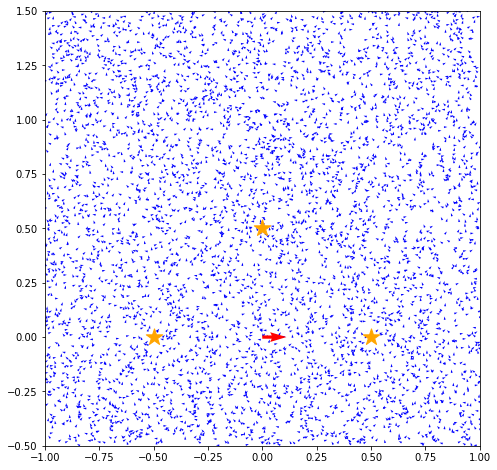

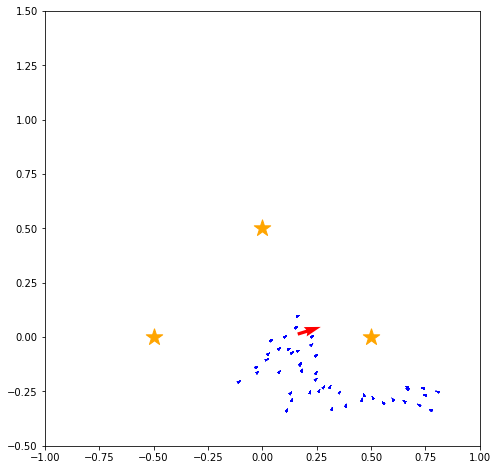

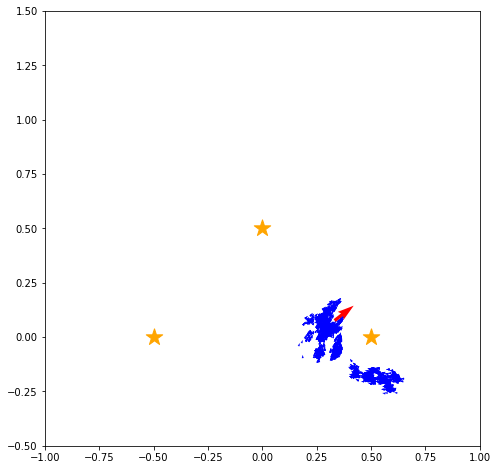

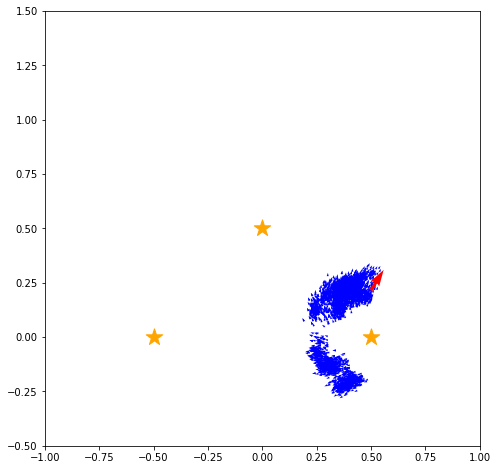

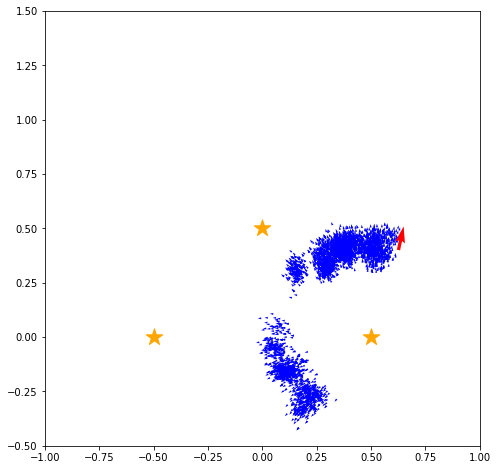

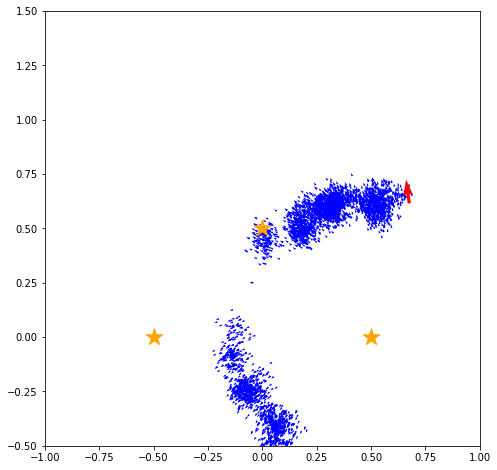

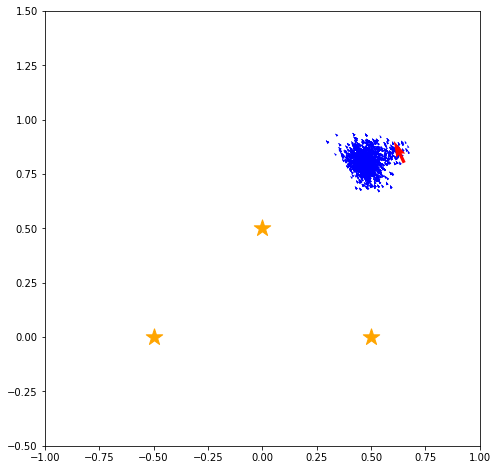

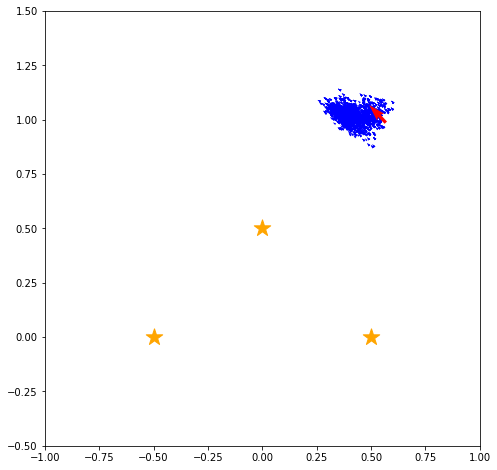

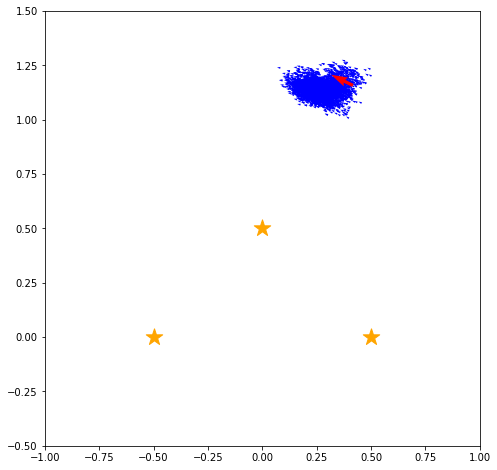

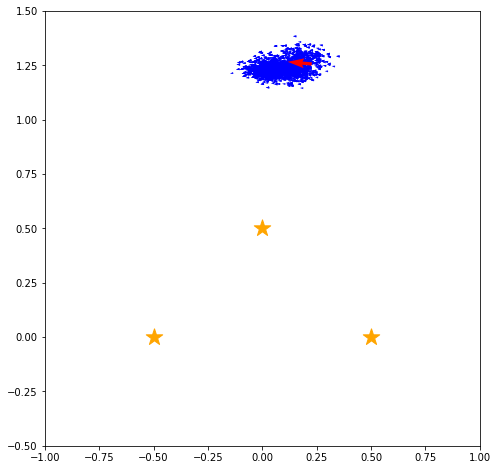

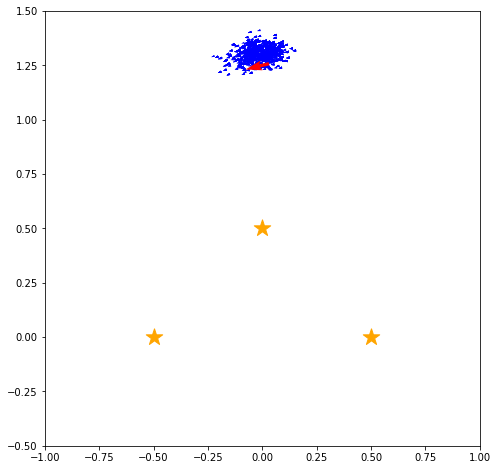

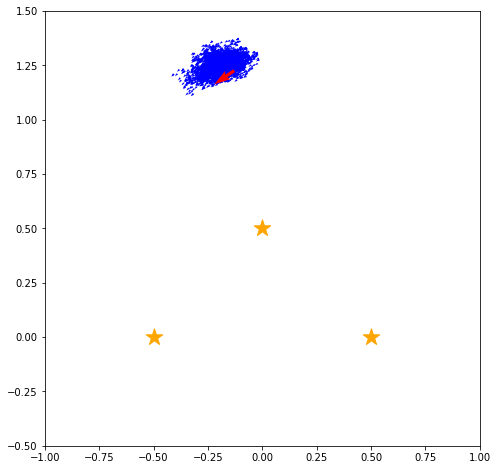

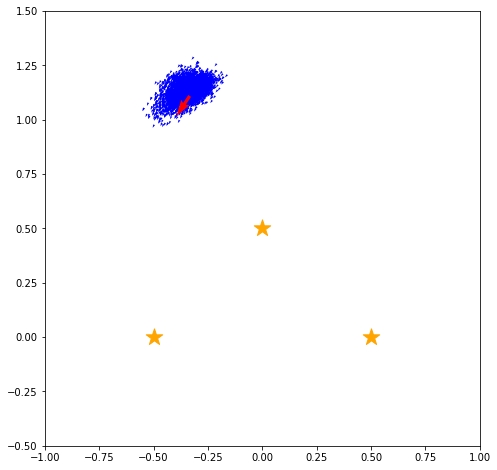

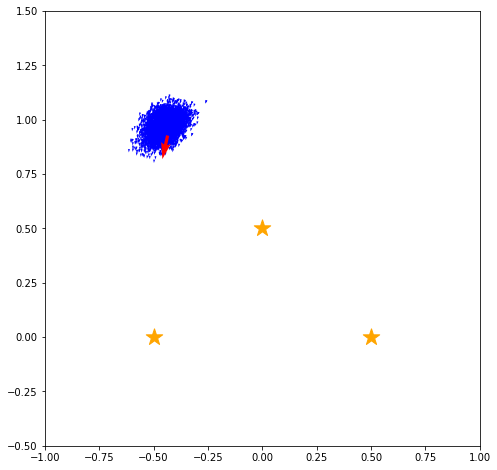

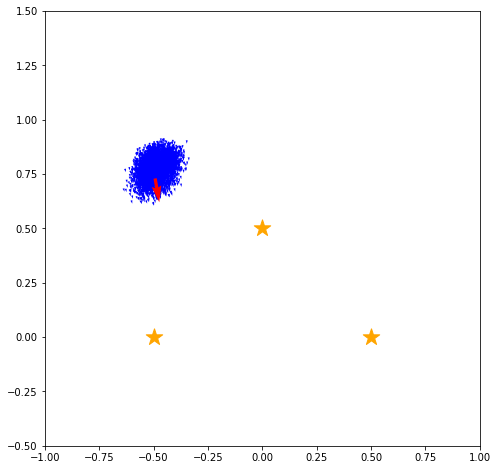

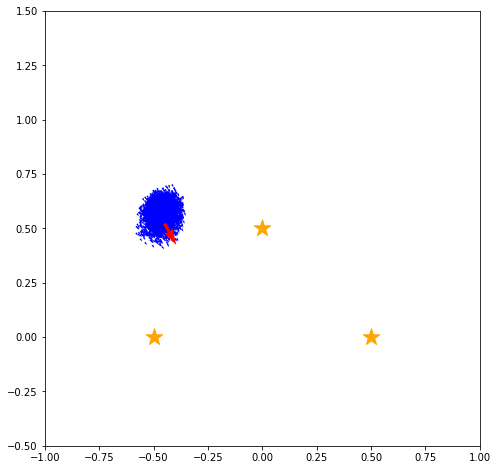

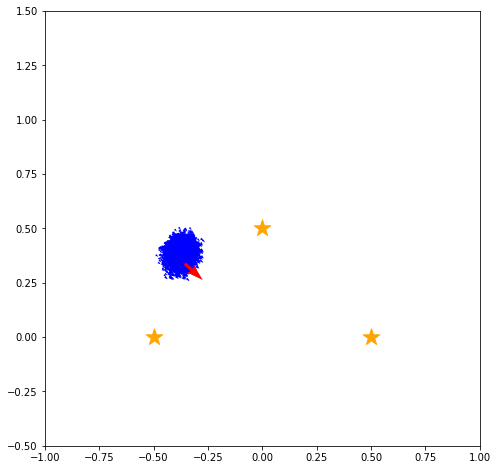

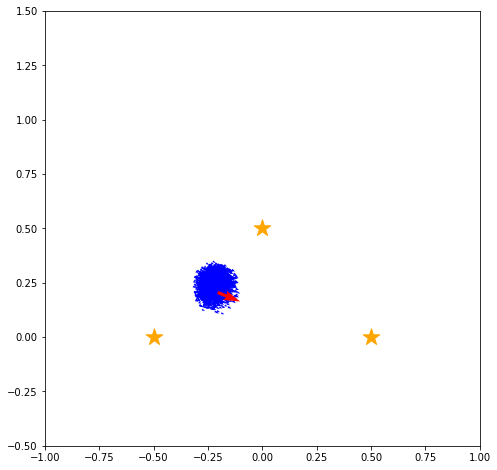

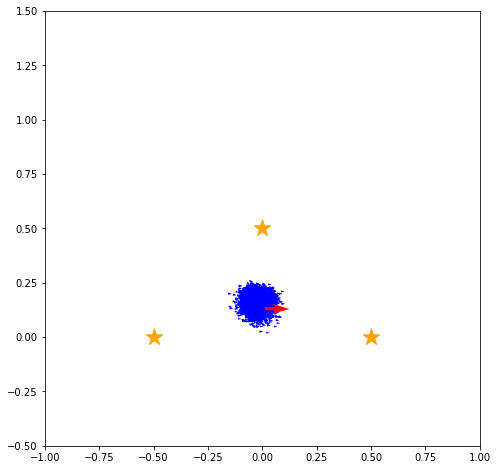

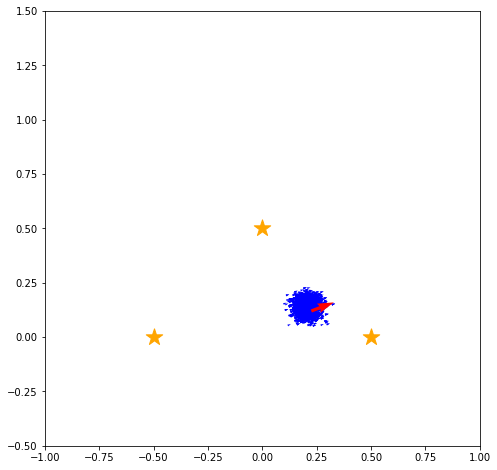

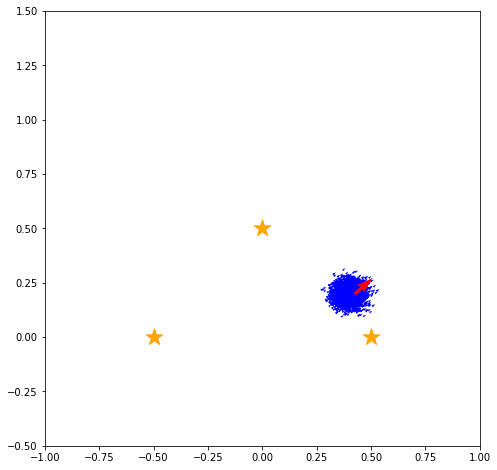

In [46]:
world.update(path, particle_path, actual_landmarks, measurements)